In [2]:
# Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve, auc
from fancyimpute import IterativeImputer
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the data
data = pd.read_csv('payment-practices.csv')

In [4]:
# Drop columns that are not useful for the model
columns_to_drop = ['Report Id','Start date', 'End date', 'Filing date', 'Company', 'Company number','URL']
data = data.drop(columns=columns_to_drop)

80th Quantile =  47.0


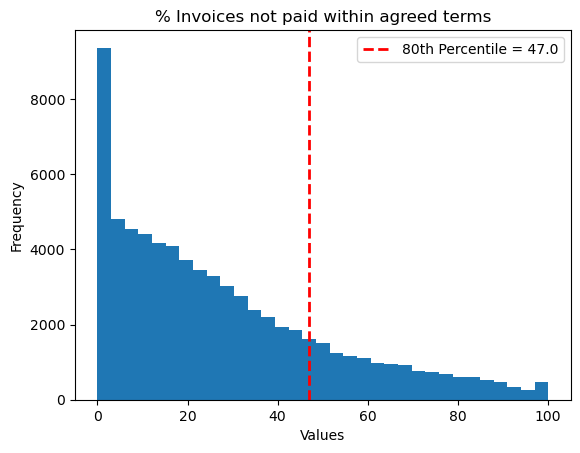

In [5]:
# Bar plot for '% Invoices not paid within agreed terms' and 80th percentile
percentile_80 = np.percentile(data['% Invoices not paid within agreed terms'].dropna(), 80)
print('80th Quantile = ',percentile_80)

plt.hist(data['% Invoices not paid within agreed terms'],bins=33)
plt.axvline(x=percentile_80, color='red', linestyle='dashed', linewidth=2, label='80th Percentile = '+str(percentile_80))

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('% Invoices not paid within agreed terms')

# Show the plot
plt.legend()
plt.show()

In [6]:
# assigning types of features
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object','bool']).columns
missing_data_cols = [i for i in categorical_features if data[i].isnull().sum() > 0]
non_missing_cat = [i for i in categorical_features if i not in missing_data_cols]

In [7]:
# Missing data
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,14673,18.888789
Average time to pay,6859,8.829701
% Invoices paid within 30 days,6859,8.829701
% Invoices paid between 31 and 60 days,6859,8.829701
% Invoices paid later than 60 days,6859,8.829701
% Invoices not paid within agreed terms,6708,8.635316
Shortest (or only) standard payment period,6708,8.635316
Longest standard payment period,30562,39.342954
Maximum contractual payment period,6708,8.635316
Payment terms have changed,6708,8.635316


Handling missing data

In [8]:
mice_imputer = IterativeImputer()
data_imputed = mice_imputer.fit_transform(data)
data_imputed = pd.DataFrame(data_imputed, columns=data.columns)
data = data_imputed

In [9]:
data = data.astype('int')

In [10]:
#missing data
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,0,0.0
Average time to pay,0,0.0
% Invoices paid within 30 days,0,0.0
% Invoices paid between 31 and 60 days,0,0.0
% Invoices paid later than 60 days,0,0.0
% Invoices not paid within agreed terms,0,0.0
Shortest (or only) standard payment period,0,0.0
Longest standard payment period,0,0.0
Maximum contractual payment period,0,0.0
Payment terms have changed,0,0.0


In [11]:
# Creating target column 'flag' based on the 80th percentile
percentile_80 = np.percentile(data['% Invoices not paid within agreed terms'].dropna(), 80)
data['flag'] = 0
data.loc[data['% Invoices not paid within agreed terms'] > percentile_80, 'flag'] = 1
data.drop(columns=['% Invoices not paid within agreed terms'],inplace=True)

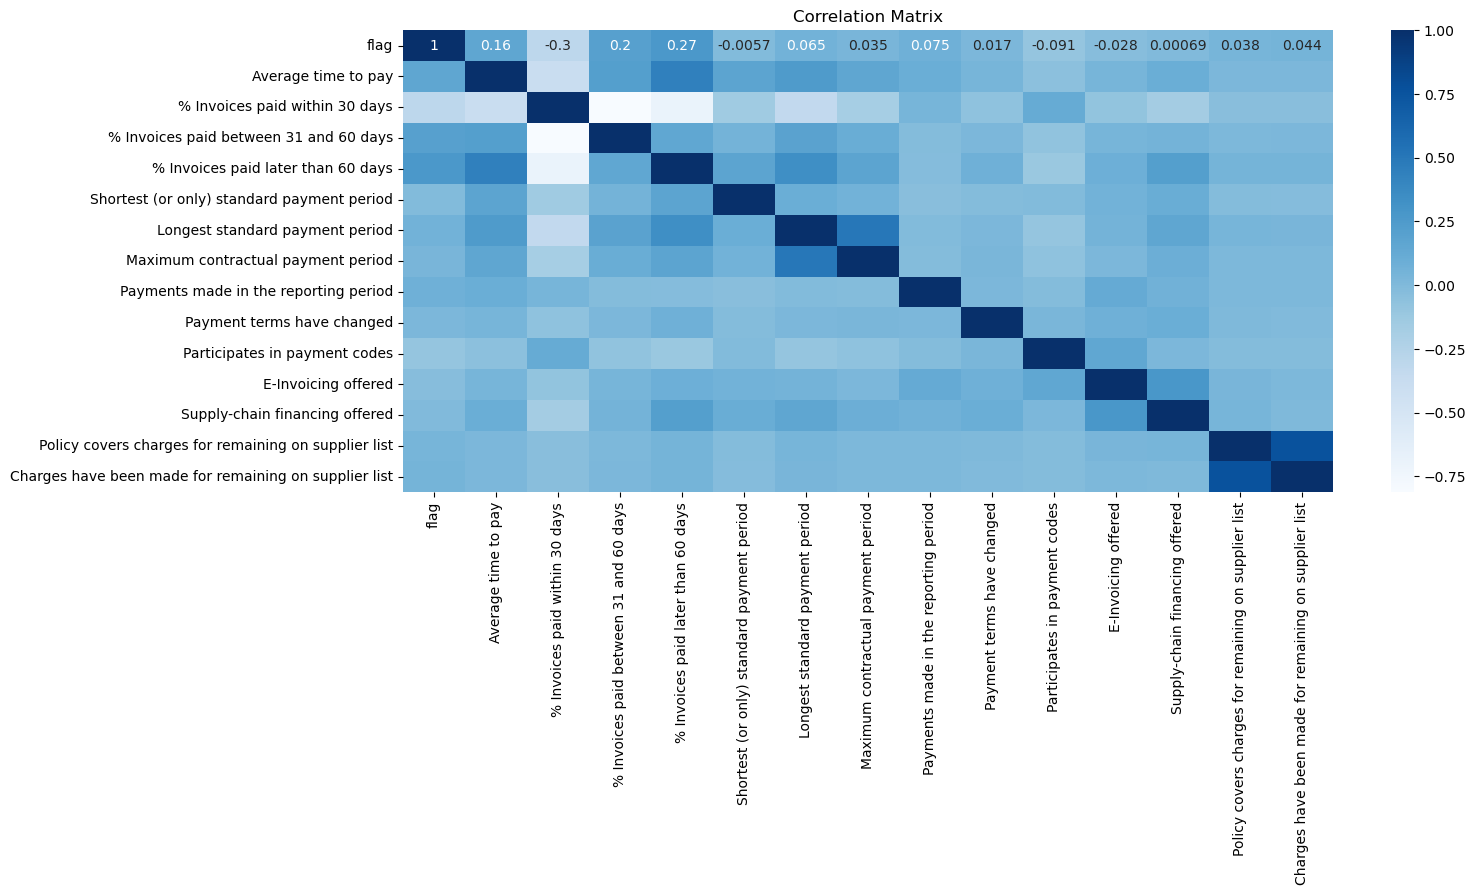

In [12]:
new_order=[     'flag',
                'Average time to pay',
                '% Invoices paid within 30 days',
                '% Invoices paid between 31 and 60 days',
                '% Invoices paid later than 60 days',
                'Shortest (or only) standard payment period',
                'Longest standard payment period', 'Maximum contractual payment period',
                'Payments made in the reporting period',
                'Payment terms have changed', 'Participates in payment codes',
                'E-Invoicing offered', 'Supply-chain financing offered',
                'Policy covers charges for remaining on supplier list',
                'Charges have been made for remaining on supplier list']
# Visualize the relationship between numerical columns using a correlation matrix
data = data.reindex(columns=new_order)
correlation_matrix = data.reindex(columns=new_order).corr()
plt.figure(figsize=(15, 6))
sns.heatmap(correlation_matrix,annot=True,cmap='Blues')
plt.title('Correlation Matrix')
plt.show()


In [13]:
# Dropping the Highly correlated Features
data1 = data.drop(columns=[ '% Invoices paid within 30 days', 
                            '% Invoices paid later than 60 days',
                            'Policy covers charges for remaining on supplier list'])

In [14]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(data1.drop(columns=['flag']), data1['flag'], test_size=0.3, random_state=42)

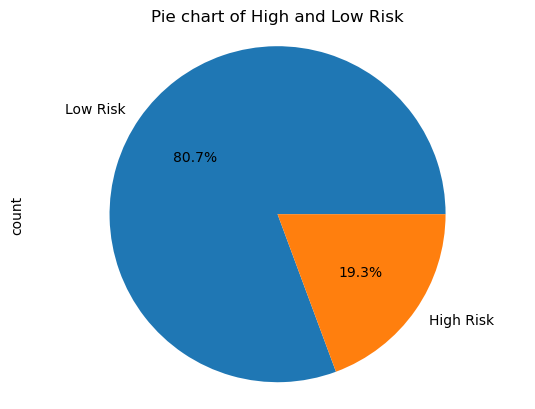

In [15]:
# Pie chart of High and Low Risk before Sampling
y_train.value_counts().plot.pie(autopct='%1.1f%%',labels=['Low Risk','High Risk'])
plt.axis('equal')
plt.title('Pie chart of High and Low Risk')
plt.show()

In [16]:
# Implemeting the RandomOverSampler
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler()
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

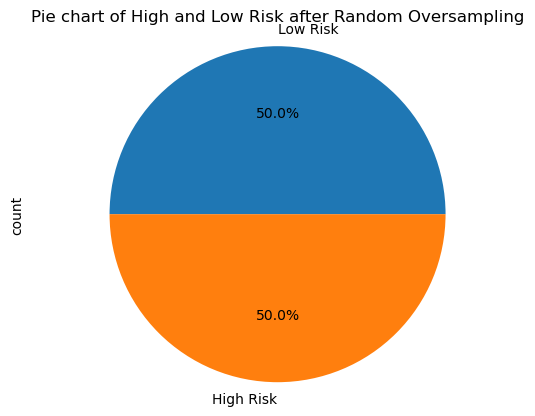

In [17]:
# pie chart of High and Low Risk after Random Oversampling
y_train_oversampled.value_counts().plot.pie(autopct='%1.1f%%',labels=['Low Risk','High Risk'])
plt.axis('equal')
plt.title('Pie chart of High and Low Risk after Random Oversampling')
plt.show()

XGBoost

In [18]:
# XGBoost Model
params = {
    'learning_rate': 0.01,
    'max_depth': 10,
    'min_child_weight': 1,
    'subsample': 0.85,
    'n_estimators': 900,
} 

xgb_clf = XGBRegressor(**params)

xgb_clf.fit(X_train_oversampled, y_train_oversampled)

y_pred = xgb_clf.predict(X_test)
y_pred1 = np.where(y_pred > 0.5, 1, 0)
# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred1)
print('XGBoost model accuracy score: ', accuracy)

# Calculate F1 Score
f1 = f1_score(y_test, y_pred1)
print('F1 Score:', f1)

# Calculate ROC AUC Score
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('ROC AUC Score:', roc_auc)


XGBoost model accuracy score:  0.8051062003861832
F1 Score: 0.5950427960057061
ROC AUC Score: 0.8672938247011953


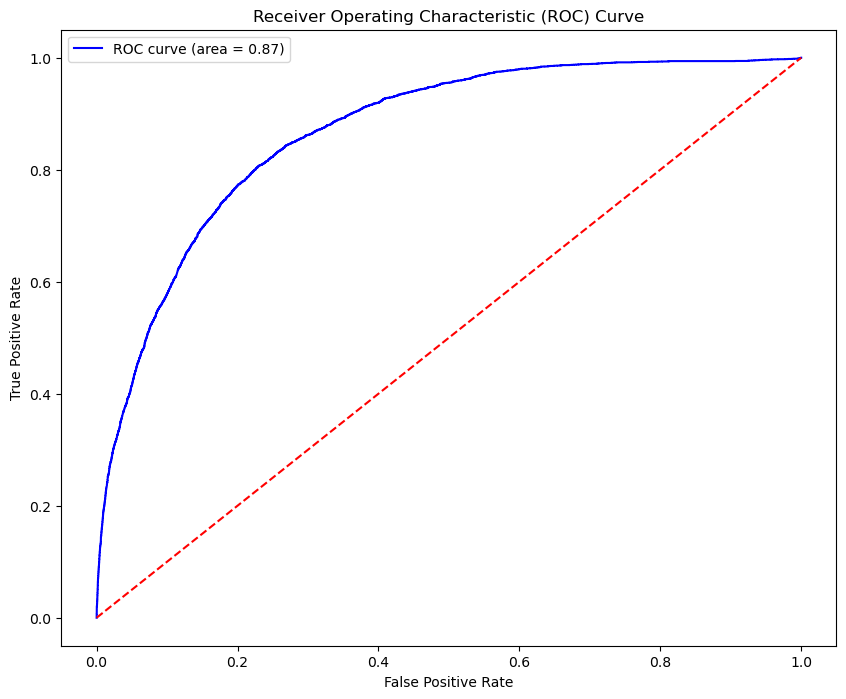

In [19]:
# Plot the ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [20]:
import joblib

# Save the model
joblib.dump(xgb_clf, 'model.pkl')

['model.pkl']

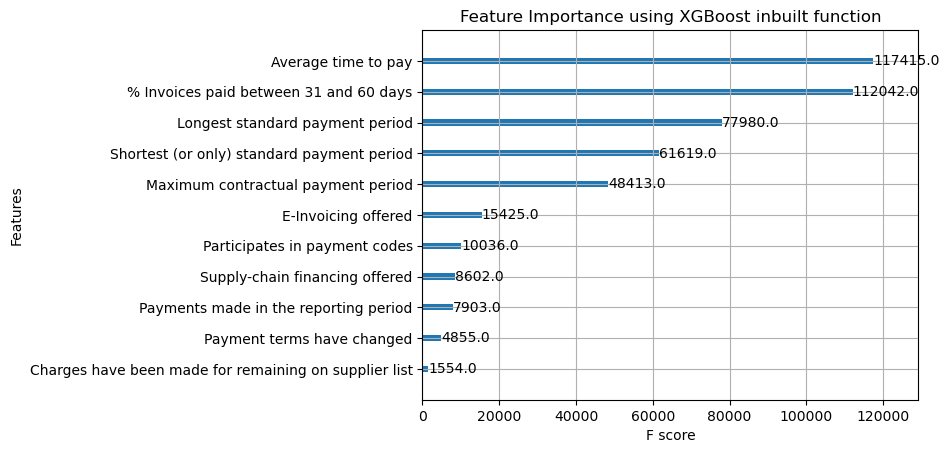

In [21]:
# Feature Importance using XGBoost inbuilt function
xgb.plot_importance(xgb_clf)
plt.rcParams['figure.figsize'] = [6, 4]
plt.title('Feature Importance using XGBoost inbuilt function') 
plt.show()

In [22]:
X_test.iloc[1000]

Average time to pay                                      30
% Invoices paid between 31 and 60 days                   37
Shortest (or only) standard payment period                7
Longest standard payment period                          60
Maximum contractual payment period                       60
Payments made in the reporting period                     1
Payment terms have changed                                0
Participates in payment codes                             1
E-Invoicing offered                                       0
Supply-chain financing offered                            0
Charges have been made for remaining on supplier list     0
Name: 474, dtype: int32

In [23]:
y_pred[1000]

0.5483732

In [24]:
# Predict using the trained model
prediction = xgb_clf.predict([[30, 37, 7, 60, 60, True, False, True, False, False, False]])

# Print the prediction
print(prediction)


[0.5483732]


In [25]:
import joblib

# Load the saved model
loaded_model = joblib.load('model.pkl')

# Make predictions using the loaded model
prediction = loaded_model.predict([[55, 57, 1, 90, 90, True, False, False, False, False, False]])

# Print the prediction
print(prediction)


[0.71364355]
